In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.io import wavfile
import os
from pydub import AudioSegment
from matplotlib.pyplot import *

%matplotlib inline

In [12]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [13]:
df = pd.read_feather('vocalization_df.feather')

df_c2 = df[df.cohort=='c2']
df_c4 = df[df.cohort=='c4']
df_c5 = df[df.cohort=='c5']

In [14]:
#where to put examples
border_positions = np.array([[0,0],
                             [0,1],
                             [0,2],
                             [0,3],
                             [1,3],
                             [2,3],
                             [3,3],
                             [3,2],
                             [3,1],
                             [3,0],
                             [2,0],
                             [1,0]])
#which examples to pick
indicies = np.array([[3, 10],
                     [9, 10],
                     [5, 1],
                     [2, 1],
                     [2, 10],
                     [9, 8],
                     [6, 10],
                     [10, 6],
                     [2, 8],
                     [3, 1],
                     [1, 2],
                     [1, 6]])-1

indicies_flat = [np.ravel_multi_index(indicies[i], (10,10)) for i in range(len(indicies))]

#which cluster example comes from
states = np.array([8, 66, 38, 17, 19, 30, 51, 59, 31, 36, 57, 5])

In [15]:
#get the index of the example

example_idx = []

for i in range(len(states)):
    n_samples = 100
    df_sub = df_c2[df_c2.z_70 == states[i]]
    prob_z_70 = np.array([df_sub['prob_z_70'].values[j][states[i]] for j in range(len(df_sub))])
    sortby_prob = np.argsort(prob_z_70)[::-1]
    df_sub = df_sub.iloc[sortby_prob[:n_samples]]
    
    example_idx.append(df_sub.index[indicies_flat[i]])

In [16]:
#make a df containing the subset of examples you want to show
df_example = df_c2.iloc[example_idx]

C:\Users\rep359\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


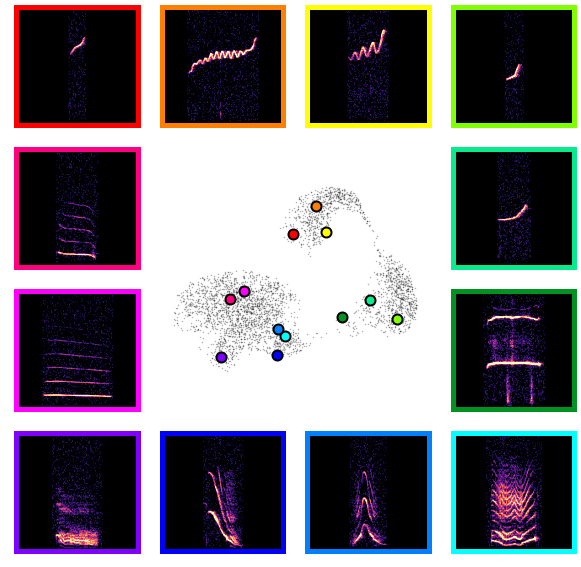

In [17]:
# loop through the examples, load the raw audio, plot on the outer grid 
# and plot the corresponding point on the UMAP embedding
audio_basename = 'cohort2_combined_audio'
fs=125000

fig = figure(figsize=(10,10))
gs = fig.add_gridspec(4,4)

colors = ['#ff0000', 
'#ff8000', 
'#ffff00',
'#80ff00',
'#08eb8c',
'#029221',
'#00ffff',
'#0080ff',
'#0000ff',
'#8000ff',
'#ff00ff',
'#ff0080']

for i in range(len(border_positions)):
    
    working_onset, working_offset = df_example.onset.values[i], df_example.offset.values[i]
    working_filename = df_example.audio_filename.values[i]

    working_audio_slice = AudioSegment.from_file(os.path.join(audio_basename, working_filename), 
                                         codec='pcm_f64le', 
                                         start_second=working_onset, 
                                         duration=working_offset-working_onset)

    working_audio = np.array(working_audio_slice.get_array_of_samples())

    v = np.zeros(int(.3*fs))
    v[int((len(v)/2) - len(working_audio)/2):int((len(v)/2) +len(working_audio)/2)] = working_audio

    ax = fig.add_subplot(gs[border_positions[i][0], border_positions[i][1]])
    
    ax.specgram(v, NFFT=512, noverlap=256, Fs=fs,clim=(-10,20), cmap='magma')
    
    ax.set_facecolor('k')
    
    ax.set_xticks([])
    ax.set_yticks([])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_color(colors[i])
        ax.spines[axis].set_linewidth(5)


ax = fig.add_subplot(gs[1:3, 1:3]) 

ax.plot(np.vstack(df_c2.latent_mean_umap.values)[::50, 0],
        np.vstack(df_c2.latent_mean_umap.values)[::50, 1], 
        '.k',
        markersize=1, alpha=0.3)

for i in range(len(colors)):
    ax.plot(np.vstack(df_example.latent_mean_umap.values)[i,0], 
            np.vstack(df_example.latent_mean_umap.values)[i,1], 
            'o',
            markersize=10,
            markeredgecolor='k',
            markeredgewidth=2,
            c=colors[i])

ax.axis('equal')
ax.axis('off');
# savefig('umap_examples.svg')